# NIR EDA

NIR is a new feature in the glacier mapper and needs to be tested. This script is mainly for visualization and some basic correlations. -> find out which features are most likely useful.

## Imports

In [92]:
import os
import sys
from typing import Dict, Any, Optional

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

# Add the parent directory to sys.path to allow imports from monthly_forecasting
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

## Config

In [93]:
data_config = {
    "path_discharge": "../../../../data/discharge/digitized_kyrgyz_hydromet/kyrgyz_hydromet_discharge_daily_2000_2023_kgz_filtered_v2.csv",
    "path_forcing": "../../../../data/forcing/ERA5_krg/HRU00003_forcing_2000-2023.csv",
    "path_static_data": "../../../../GIS/ML_Sandro/ML_basin_attributes_v2.csv",
    "path_to_sla": "../../../../data/sla_silvan/fsc_sla_timeseries_gapfilled.csv",
    "path_to_nir": "../../../../data/sla_silvan/meanNIR_TS_allBasins.csv",
    "path_to_sca": None,
    "path_to_hru_shp": None,
    "path_to_swe": "../../../../data/snow/kyrgyzstan_ts/SWE",
    "path_to_hs": "../../../../data/snow/kyrgyzstan_ts/HS",
    "path_to_rof": "../../../../data/snow/kyrgyzstan_ts/RoF",
    "HRU_SWE": "HRU_00003",
    "HRU_HS": "HRU_00003",
    "HRU_ROF": "HRU_00003",
    "model_home_path": "../../monthly_forecasting_models/GlacierMapper_Based",
}

## Data Loading

In [94]:
from monthly_forecasting.scr import data_loading as dl

# supress logging from matplotlib
import logging

logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


def load_data(data_config: Dict[str, Any], path_config: Dict[str, Any]) -> tuple:
    """
    Load data using the data loading utilities.

    Args:
        data_config: Data configuration
        path_config: Path configuration

    Returns:
        Tuple of (data, static_data)
    """
    # -------------- 1. Load Data ------------------------------
    hydro_ca, static_df = dl.load_data(
        path_discharge=path_config["path_discharge"],
        path_forcing=path_config["path_forcing"],
        path_static_data=path_config["path_static_data"],
        path_to_sca=path_config["path_to_sca"],
        path_to_swe=path_config["path_to_swe"],
        path_to_hs=path_config["path_to_hs"],
        path_to_rof=path_config["path_to_rof"],
        HRU_SWE=path_config["HRU_SWE"],
        HRU_HS=path_config["HRU_HS"],
        HRU_ROF=path_config["HRU_ROF"],
        path_to_sla=path_config.get("path_to_sla", None),
        path_to_nir=path_config.get("path_to_nir", None),
    )

    # if log_discharge in columns - drop
    if "log_discharge" in hydro_ca.columns:
        hydro_ca.drop(columns=["log_discharge"], inplace=True)

    hydro_ca = hydro_ca.sort_values("date")

    hydro_ca["code"] = hydro_ca["code"].astype(int)

    if "CODE" in static_df.columns:
        static_df.rename(columns={"CODE": "code"}, inplace=True)
    static_df["code"] = static_df["code"].astype(int)

    return hydro_ca, static_df


# Load the data
hydro_ca, static_df = load_data(data_config, data_config)

print("Data loaded successfully.")

# get the dimensions of the data
print(f"hydro_ca shape: {hydro_ca.shape}")

# get the dtype of each column
print(hydro_ca.dtypes)

# print head
print(hydro_ca.iloc[5000:5005])

Error loading SCA data: Invalid file path or buffer object type: <class 'NoneType'>


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/monthly_forecasting/scr/data_loading.py:87: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_file)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/monthly_forecasting/scr/data_loading.py:87: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path

Unique days of month in SLA data: [ 1 11 21]
Unique days of month after SLA data shift: [10 20 31 30]
Data loaded successfully.
hydro_ca shape: (551769, 18)
date                   datetime64[ns]
discharge                     float64
river                          object
code                            int64
T                             float64
P                             float64
SWE                           float64
HS                            float64
ROF                           float64
SLA_East                      float64
SLA_West                      float64
SLA_North                     float64
SLA_South                     float64
gla_area_below_sl50           float64
gla_fsc_total                 float64
gla_fsc_below_sl50            float64
fsc_basin                     float64
NIR                           float64
dtype: object
             date  discharge                               river   code  \
297724 2000-03-21       3.14  р. Куркуроо-Суу - уроч. Чон-Курчак  1531

In [95]:
feature_config = {
    "discharge": [
        {
            "operation": "mean",
            "windows": [
                15,
                30,
            ],
            "lags": {},
        },
    ],
    "P": [{"operation": "sum", "windows": [15, 30], "lags": {}}],
    "T": [{"operation": "mean", "windows": [15, 30], "lags": {}}],
    "fsc_basin": [{"operation": "last_value", "windows": [30], "lags": {}}],
    "SLA_West": [{"operation": "last_value", "windows": [30], "lags": {}}],
    "SLA_South": [{"operation": "last_value", "windows": [30], "lags": {}}],
    "SLA_East": [{"operation": "last_value", "windows": [30], "lags": {}}],
    "SLA_North": [{"operation": "last_value", "windows": [30], "lags": {}}],
    "NIR": [
        {"operation": "last_value", "windows": [30], "lags": {}},
        {"operation": "mean", "windows": [30], "lags": {}},
    ],
    "SWE": [{"operation": "mean", "windows": [15, 30], "lags": {}}],
}

In [96]:
from monthly_forecasting.scr import FeatureExtractor as FE

# Use FeatureExtractor for time series features
extractor = FE.StreamflowFeatureExtractor(
    feature_configs=feature_config,
    prediction_horizon=30,
    offset=30,
)

data = extractor.create_all_features(hydro_ca)

# only keep the last day of the month
data = data[data["date"].dt.is_month_end]

# merge static data based on code
data = data.merge(static_df[["code", "gl_fr"]], on="code", how="left")
mask_no_glaciers = data["gl_fr"] == 0.0

# fill the NIR values with 0
all_cols_with_nir = [col for col in data.columns if col.startswith("NIR_")]
data.loc[mask_no_glaciers, all_cols_with_nir] = 0.0

data_with_no_glaciers = data[data["gl_fr"] == 0.0]

print(data_with_no_glaciers.describe())

print("Features extracted successfully.")
print(f"Feature data shape: {data.shape}")
# columns
print(f"Feature data columns: {data.columns.tolist()}")

data["month"] = data["date"].dt.month

print(f"Feature data shape: {data.shape}")

2025-11-13 13:40:30,109 - monthly_forecasting.scr.FeatureExtractor - INFO - Creating features for column: discharge
2025-11-13 13:40:30,109 - monthly_forecasting.scr.FeatureExtractor - INFO - Features with column 'discharge': ['discharge']
2025-11-13 13:40:30,109 - monthly_forecasting.scr.FeatureExtractor - INFO - Configuration for column 'discharge': [{'operation': 'mean', 'windows': [15, 30], 'lags': {}}]
2025-11-13 13:40:30,284 - monthly_forecasting.scr.FeatureExtractor - INFO - Creating features for column: P
2025-11-13 13:40:30,284 - monthly_forecasting.scr.FeatureExtractor - INFO - Features with column 'P': ['P']
2025-11-13 13:40:30,285 - monthly_forecasting.scr.FeatureExtractor - INFO - Configuration for column 'P': [{'operation': 'sum', 'windows': [15, 30], 'lags': {}}]
2025-11-13 13:40:30,417 - monthly_forecasting.scr.FeatureExtractor - INFO - Creating features for column: T
2025-11-13 13:40:30,418 - monthly_forecasting.scr.FeatureExtractor - INFO - Features with column 'T': [

                      date          code       target  discharge_roll_mean_15  \
count                 1152   1152.000000  1002.000000             1003.000000   
mean   2012-01-14 21:30:00  16137.750000     6.822839                6.849160   
min    2000-01-31 00:00:00  16134.000000     0.100000                0.070000   
25%    2006-01-23 06:00:00  16134.750000     1.247583                1.255667   
50%    2012-01-15 12:00:00  16137.000000     2.267333                2.210667   
75%    2018-01-07 18:00:00  16140.000000     6.106750                5.870000   
max    2023-12-31 00:00:00  16143.000000   122.366667              150.600000   
std                    NaN      3.563499    13.895136               14.423478   

       discharge_roll_mean_30  P_roll_sum_15  P_roll_sum_30  T_roll_mean_15  \
count             1006.000000    1136.000000    1136.000000     1136.000000   
mean                 6.806255      41.248874      81.204120        5.787246   
min                  0.100000    

## Visualization

In [66]:
def plot_monthly_correlation(
    data: pd.DataFrame,
    feature_col: str,
    target_col: str,
    *,
    month_col: str = "month",
    jitter: float = 0.2,
    point_alpha: float = 0.8,
    figsize: tuple[int, int] = (12, 6),
) -> None:
    """Plot monthly correlation distribution between a feature and a target."""
    if month_col not in data.columns:
        if "date" not in data.columns:
            raise ValueError(
                "DataFrame must contain either 'date' or the month column."
            )
        data = data.copy()
        data[month_col] = data["date"].dt.month

    required = {feature_col, target_col, month_col, "code", "gl_fr"}
    missing = required.difference(data.columns)
    if missing:
        missing_str = ", ".join(sorted(missing))
        raise ValueError(f"DataFrame is missing required columns: {missing_str}")

    gl_fractions = data[["code", "gl_fr"]].drop_duplicates().set_index("code")

    correlations = (
        data.groupby([month_col, "code"], dropna=False)
        .apply(lambda df: df[feature_col].corr(df[target_col]))
        .reset_index(name="correlation")
        .dropna(subset=["correlation"])
    )

    # merge gl_fr
    correlations = correlations.join(gl_fractions, on="code")

    plt.figure(figsize=figsize)
    sns.boxplot(
        data=correlations,
        x=month_col,
        y="correlation",
        fill=False,
        color="lightgray",
    )
    # color based on gl_fr
    sns.stripplot(
        data=correlations,
        x=month_col,
        y="correlation",
        hue="gl_fr",
        alpha=point_alpha,
        palette="magma",
        jitter=jitter,
    )
    # add a color legend
    plt.legend(title="gl_fr", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.title(f"Correlation between {feature_col} and {target_col} by Month")
    plt.xlabel("Month")
    plt.ylabel("Correlation Coefficient")
    plt.ylim(-1, 1)
    plt.axhline(0, color="red", linestyle="--")
    plt.show()

/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_46423/2154299270.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this w

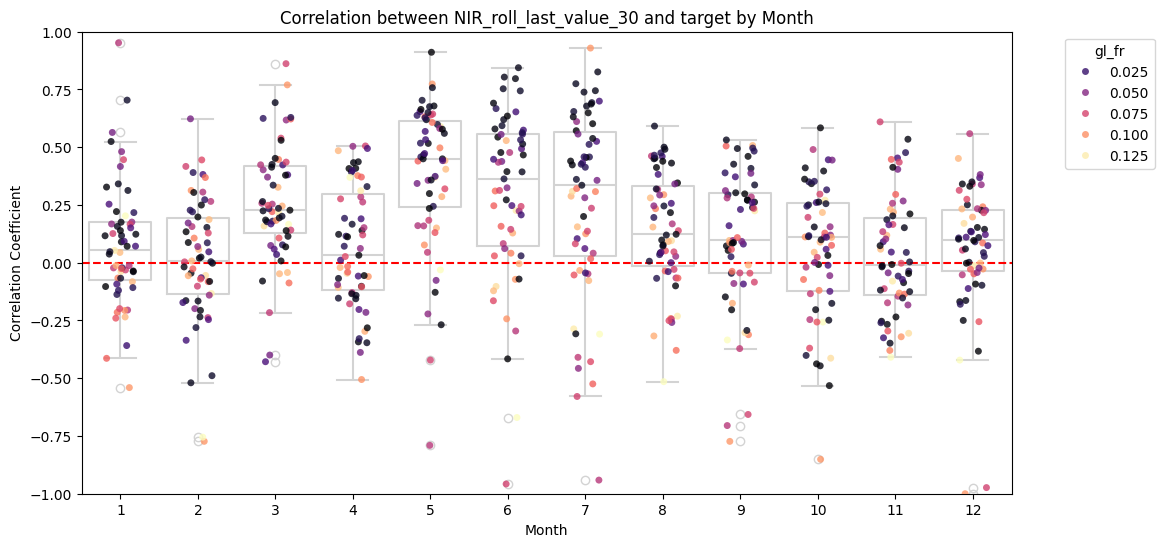

/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_46423/2154299270.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this w

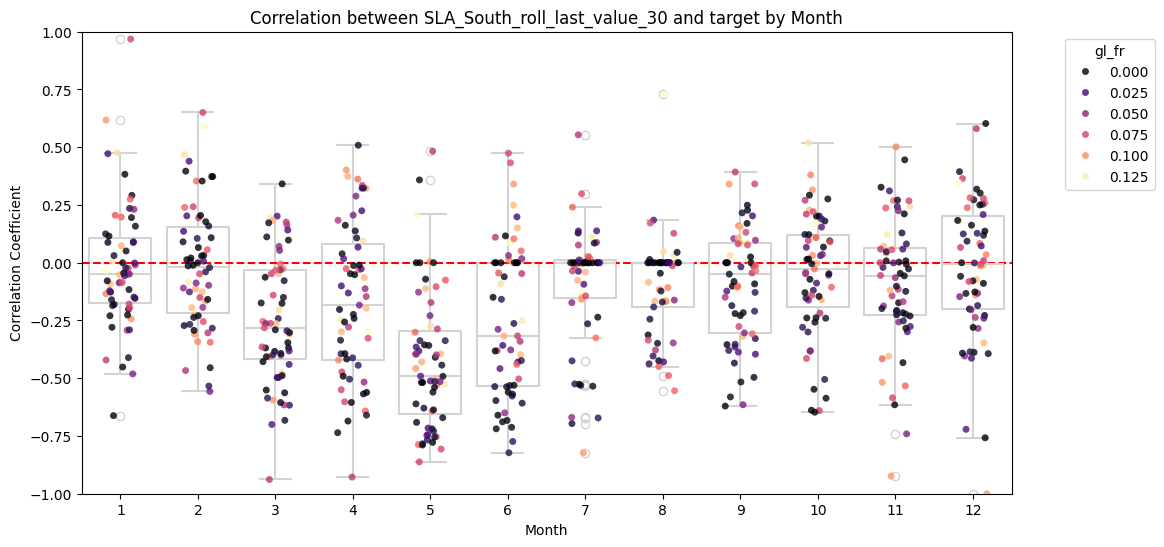

/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_46423/2154299270.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this w

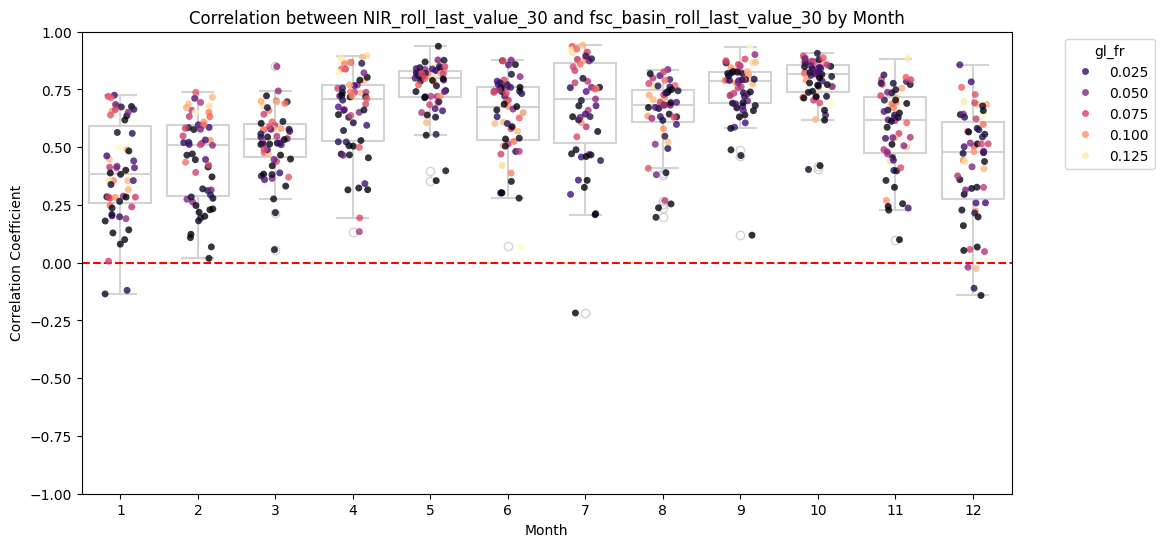

/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_46423/2154299270.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this w

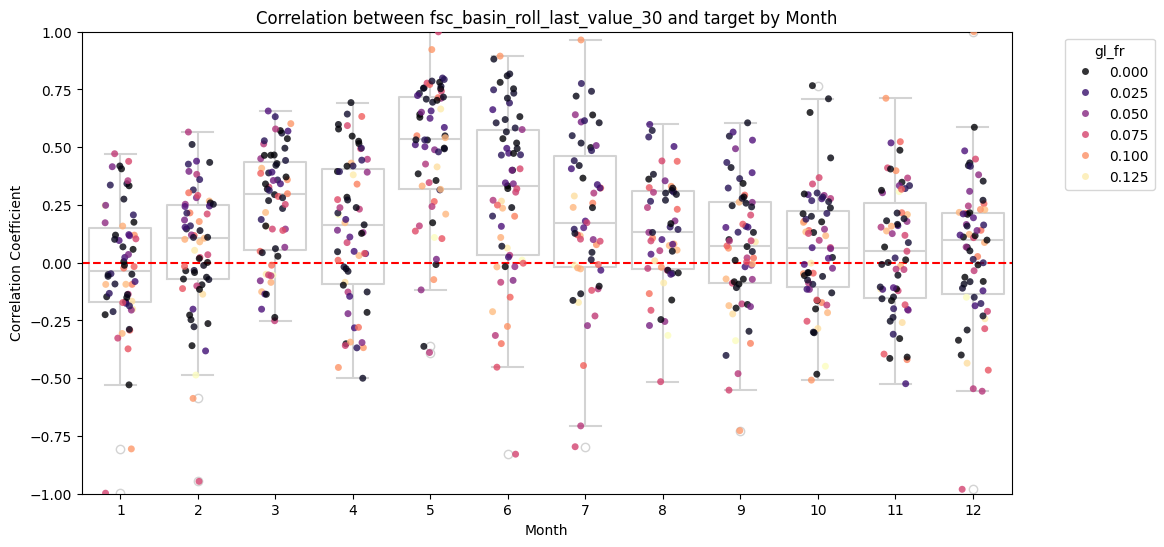

/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_46423/2154299270.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df[feature_col].corr(df[target_col]))


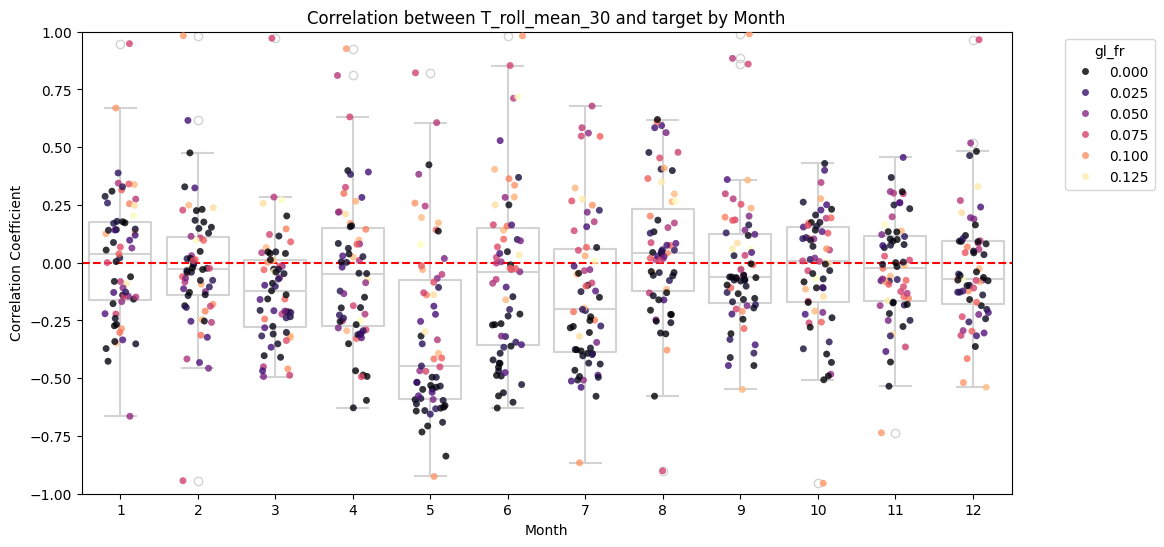

/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_46423/2154299270.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df[feature_col].corr(df[target_col]))


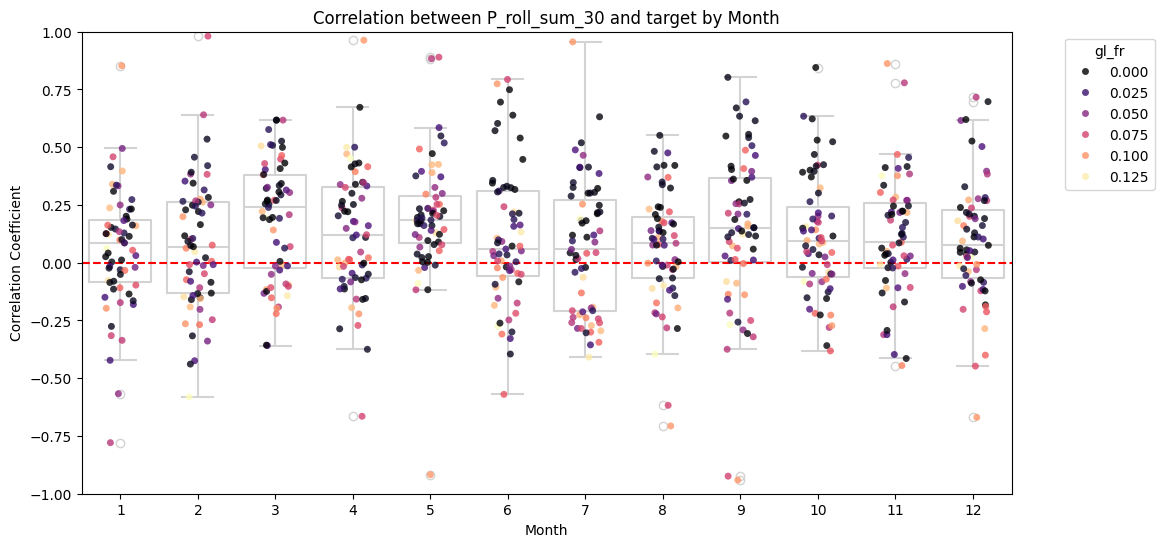

/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_46423/2154299270.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df[feature_col].corr(df[target_col]))


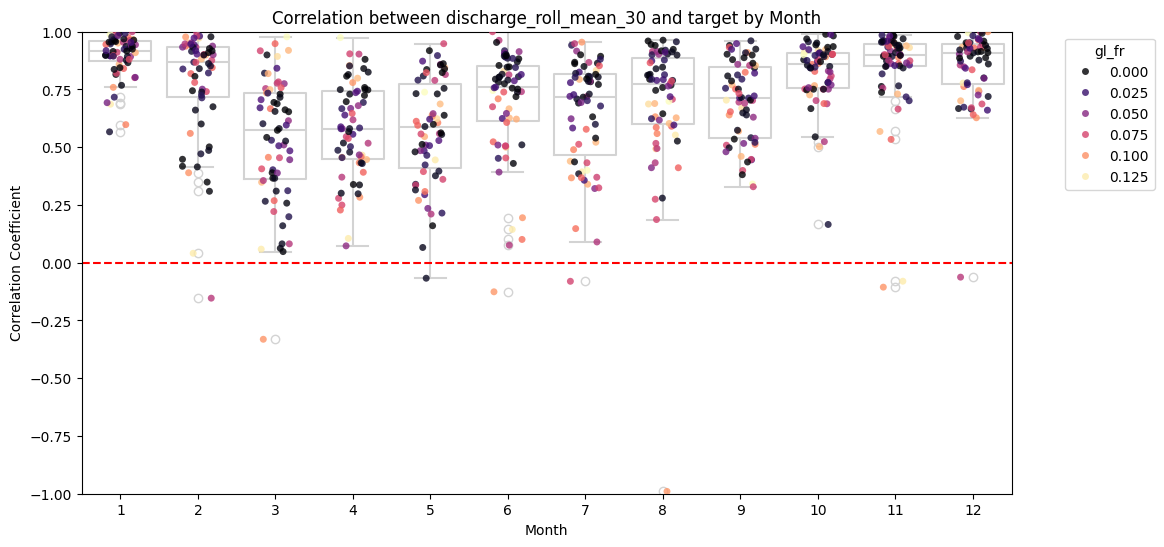

/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_46423/2154299270.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df[feature_col].corr(df[target_col]))


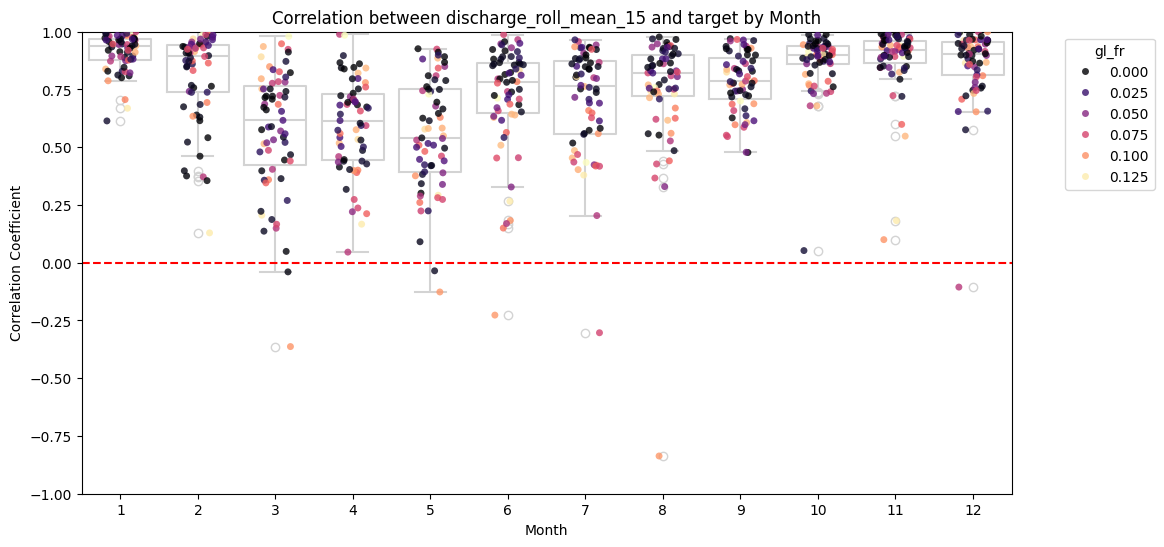

/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_46423/2154299270.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this w

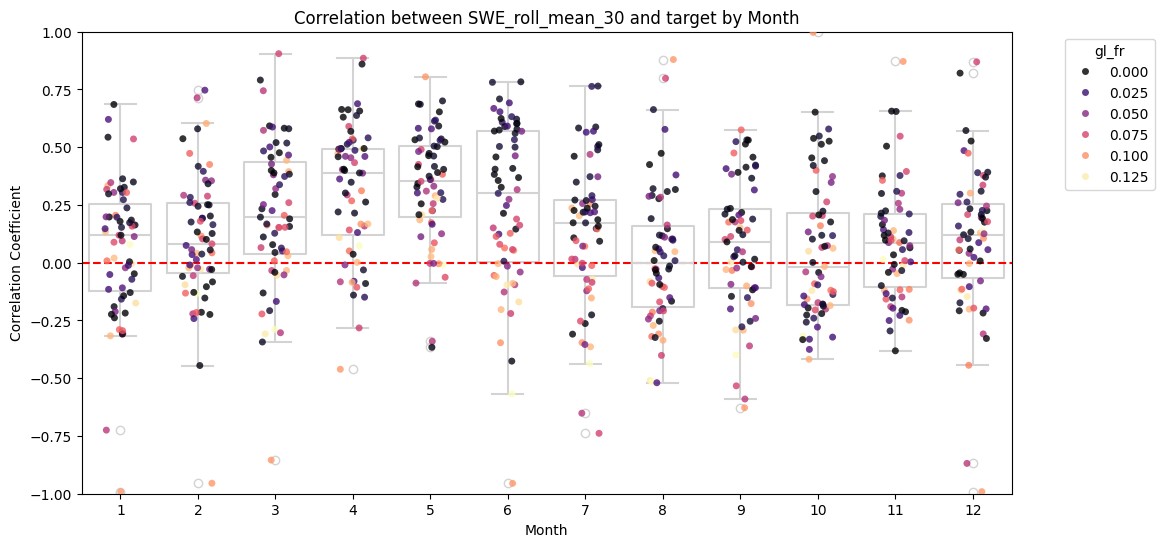

/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_46423/2154299270.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this w

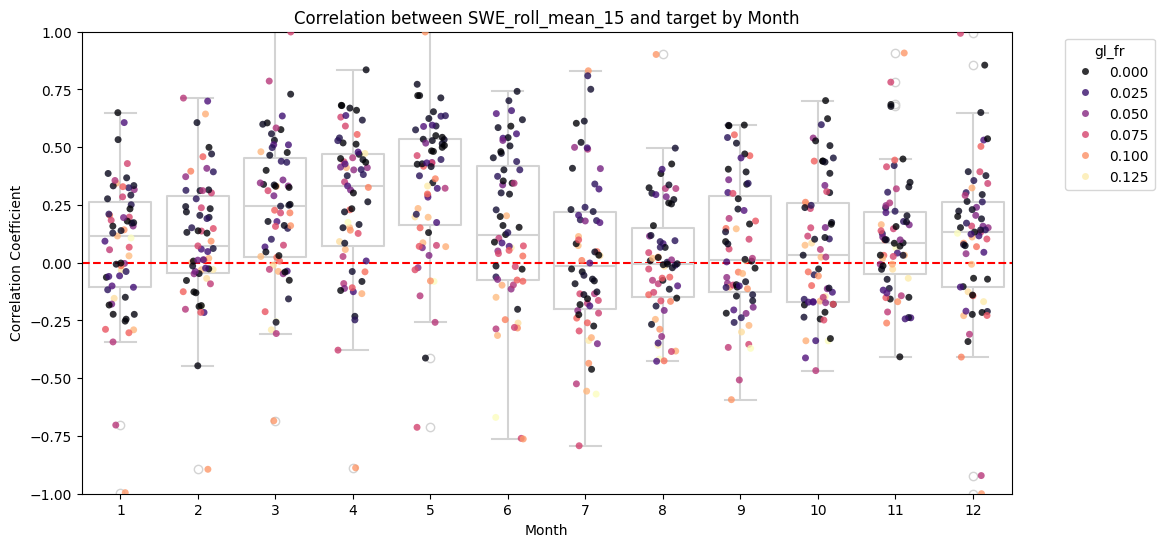

In [67]:
# plot the correlation of NIR against the 'target' for each month and basin
plot_monthly_correlation(
    data, feature_col="NIR_roll_last_value_30", target_col="target"
)
# SLA
plot_monthly_correlation(
    data,
    feature_col="SLA_South_roll_last_value_30",
    target_col="target",
)
plot_monthly_correlation(
    data,
    feature_col="NIR_roll_last_value_30",
    target_col="fsc_basin_roll_last_value_30",
)
plot_monthly_correlation(
    data, feature_col="fsc_basin_roll_last_value_30", target_col="target"
)
plot_monthly_correlation(data, feature_col="T_roll_mean_30", target_col="target")
plot_monthly_correlation(data, feature_col="P_roll_sum_30", target_col="target")
# with the discharge lags
plot_monthly_correlation(
    data, feature_col="discharge_roll_mean_30", target_col="target"
)
plot_monthly_correlation(
    data, feature_col="discharge_roll_mean_15", target_col="target"
)
# swe
plot_monthly_correlation(data, feature_col="SWE_roll_mean_30", target_col="target")
plot_monthly_correlation(data, feature_col="SWE_roll_mean_15", target_col="target")

## Whole feature set

In [68]:
feature_config = {
    "discharge": [
        {"operation": "mean", "windows": [7, 15, 30], "lags": {"30": [30, 330, 365]}},
        {"operation": "slope", "windows": [7, 15], "lags": {}},
        {"operation": "peak_to_peak", "windows": [30], "lags": {}},
        {"operation": "max", "windows": [30], "lags": {}},
    ],
    "P": [{"operation": "sum", "windows": [15, 30], "lags": {"15": [-15], "30": [30]}}],
    "T": [
        {
            "operation": "mean",
            "windows": [5, 15, 30],
            "lags": {"15": [-15], "30": [30]},
        },
        {"operation": "slope", "windows": [5, 15], "lags": {"15": [-15]}},
        {"operation": "max", "windows": [30], "lags": {}},
        {"operation": "min", "windows": [30], "lags": {}},
    ],
    "SLA_Avr": [{"operation": "last_value", "windows": [30], "lags": {"30": [365]}}],
    "gla_fsc_total": [{"operation": "last_value", "windows": [30], "lags": {}}],
    "fsc_basin": [
        {"operation": "last_value", "windows": [30], "lags": {"30": [10, 20, 30]}},
        {
            "operation": "mean_difference",
            "windows": [20, 30],
            "lags": {"20": [10, 20, 30]},
        },
    ],
    "NIR": [{"operation": "last_value", "windows": [30], "lags": {}}],
}

In [ ]:
# get features
data_mm = hydro_ca.copy()
code_drop = []
for code in data_mm["code"].unique():
    mask_code = data_mm["code"] == code
    if code not in static_df["code"].values:
        logger.warning(f"Code {code} not found in static data. Skipping.")
        code_drop.append(code)
        continue
    area_km2 = static_df.loc[static_df["code"] == code, "area_km2"].values[0]
    data_mm.loc[mask_code, "discharge"] = (
        data_mm.loc[mask_code, "discharge"] * 86400 * 30 / (area_km2 * 1e6)
    )

if code_drop:
    data_mm = data_mm[~data_mm["code"].isin(code_drop)]


extractor = FE.StreamflowFeatureExtractor(
    feature_configs=feature_config,
    prediction_horizon=30,
    offset=30,
)
data = extractor.create_all_features(data_mm)

static_df = static_df[["code", "gl_fr"]]
static_df["code"] = static_df["code"].astype(int)
data["month"] = data["date"].dt.month
data = data.merge(static_df, on="code", how="left")


print(data.describe())

2025-11-13 13:32:18,732 - monthly_forecasting.scr.FeatureExtractor - INFO - Creating features for column: discharge
2025-11-13 13:32:18,733 - monthly_forecasting.scr.FeatureExtractor - INFO - Features with column 'discharge': ['discharge']
2025-11-13 13:32:18,733 - monthly_forecasting.scr.FeatureExtractor - INFO - Configuration for column 'discharge': [{'operation': 'mean', 'windows': [7, 15, 30], 'lags': {'30': [30, 330, 365]}}, {'operation': 'slope', 'windows': [7, 15], 'lags': {}}, {'operation': 'peak_to_peak', 'windows': [30], 'lags': {}}, {'operation': 'max', 'windows': [30], 'lags': {}}]
2025-11-13 13:32:33,344 - monthly_forecasting.scr.FeatureExtractor - INFO - Creating features for column: P
2025-11-13 13:32:33,345 - monthly_forecasting.scr.FeatureExtractor - INFO - Features with column 'P': ['P']
2025-11-13 13:32:33,345 - monthly_forecasting.scr.FeatureExtractor - INFO - Configuration for column 'P': [{'operation': 'sum', 'windows': [15, 30], 'lags': {'15': [-15], '30': [30]}}

                                date      code        target  \
count                         551769  551769.0  4.402930e+05   
mean   2011-12-28 17:23:39.248272640       0.0 -1.109484e-17   
min              2000-01-01 00:00:00       0.0 -1.694317e+00   
25%              2005-12-30 00:00:00       0.0 -7.119497e-01   
50%              2011-12-29 00:00:00       0.0 -4.313324e-01   
75%              2017-12-26 00:00:00       0.0  4.851221e-01   
max              2023-12-31 00:00:00       0.0  9.507966e+00   
std                              NaN       0.0  1.000001e+00   

       discharge_roll_mean_7  discharge_roll_mean_15  discharge_roll_mean_30  \
count           4.405770e+05            4.399810e+05            4.410450e+05   
mean           -7.950882e-18            3.134598e-17           -1.060067e-17   
min            -1.666068e+00           -1.697423e+00           -1.694317e+00   
25%            -6.897909e-01           -6.981169e-01           -7.114105e-01   
50%            -4.29674

## Partial Correlation Analysis

Analyze the partial correlation between NIR and target, controlling for discharge, T, and P.

In [59]:
def calculate_partial_correlations(
    data: pd.DataFrame,
    x_col: str,
    y_col: str,
    covar_cols: list[str],
    *,
    month_col: str = "month",
) -> pd.DataFrame:
    """
    Calculate partial correlation between x and y, controlling for covariates.

    Args:
        data: DataFrame containing the data
        x_col: Name of the x variable column (e.g., 'NIR_roll_last_value_30')
        y_col: Name of the y variable column (e.g., 'target')
        covar_cols: List of covariate column names to control for
        month_col: Name of the month column

    Returns:
        DataFrame with partial correlations for each code and month
    """
    required = {x_col, y_col, month_col, "code"}.union(set(covar_cols))
    missing = required.difference(data.columns)
    if missing:
        missing_str = ", ".join(sorted(missing))
        raise ValueError(f"DataFrame is missing required columns: {missing_str}")

    results = []

    for month in sorted(data[month_col].unique()):
        for code in sorted(data["code"].unique()):
            # Filter data for this month and code
            mask = (data[month_col] == month) & (data["code"] == code)
            subset = data.loc[mask, [x_col, y_col] + covar_cols].dropna()

            # Need at least n_covariates + 3 observations for partial correlation
            if len(subset) < len(covar_cols) + 3:
                continue

            try:
                # Calculate partial correlation using pingouin
                pcorr = pg.partial_corr(
                    data=subset,
                    x=x_col,
                    y=y_col,
                    covar=covar_cols,
                )

                results.append(
                    {
                        "month": month,
                        "code": code,
                        "partial_correlation": pcorr["r"].values[0],
                        "p_value": pcorr["p-val"].values[0],
                    }
                )
            except Exception as e:
                # Skip if calculation fails
                logger.debug(f"Failed for month={month}, code={code}: {e}")
                continue

    return pd.DataFrame(results)


def plot_monthly_partial_correlation(
    partial_corr_df: pd.DataFrame,
    gl_fractions: pd.DataFrame,
    x_col: str,
    y_col: str,
    covar_names: list[str],
    *,
    jitter: float = 0.2,
    point_alpha: float = 0.8,
    figsize: tuple[int, int] = (12, 6),
) -> None:
    """
    Plot boxplots of partial correlations by month.

    Args:
        partial_corr_df: DataFrame with columns ['month', 'code', 'partial_correlation']
        gl_fractions: DataFrame with glacier fractions indexed by code
        x_col: Name of x variable (for title)
        y_col: Name of y variable (for title)
        covar_names: List of covariate names (for title)
        jitter: Amount of jitter for strip plot
        point_alpha: Transparency of points
        figsize: Figure size tuple
    """
    # Merge glacier fractions
    plot_data = partial_corr_df.merge(gl_fractions.reset_index(), on="code", how="left")

    plt.figure(figsize=figsize)
    sns.boxplot(
        data=plot_data,
        x="month",
        y="partial_correlation",
        fill=False,
        color="lightgray",
    )
    sns.stripplot(
        data=plot_data,
        x="month",
        y="partial_correlation",
        hue="gl_fr",
        alpha=point_alpha,
        palette="magma",
        jitter=jitter,
    )
    plt.legend(title="gl_fr", bbox_to_anchor=(1.05, 1), loc="upper left")

    covar_str = ", ".join(covar_names)
    plt.title(f"Partial Correlation: {x_col} vs {y_col}\n(controlling for {covar_str})")
    plt.xlabel("Month")
    plt.ylabel("Partial Correlation Coefficient")
    plt.ylim(-1, 1)
    plt.axhline(0, color="red", linestyle="--")
    plt.tight_layout()
    plt.show()

/var/folders/41/6zdzv5wn1fq6nj4hhmk75zhh0000gn/T/ipykernel_46423/1084867916.py:100: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.stripplot(
2025-11-13 13:31:39,277 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Calculating partial correlations for NIR vs target...
Controlling for: discharge_roll_mean_30, T_roll_mean_30, P_roll_sum_30

Calculated 12 partial correlations
across 1 codes and 12 months

Summary statistics:
count    12.000000
mean      0.030487
std       0.115357
min      -0.092610
25%      -0.037460
50%      -0.008039
75%       0.077671
max       0.320033
Name: partial_correlation, dtype: float64


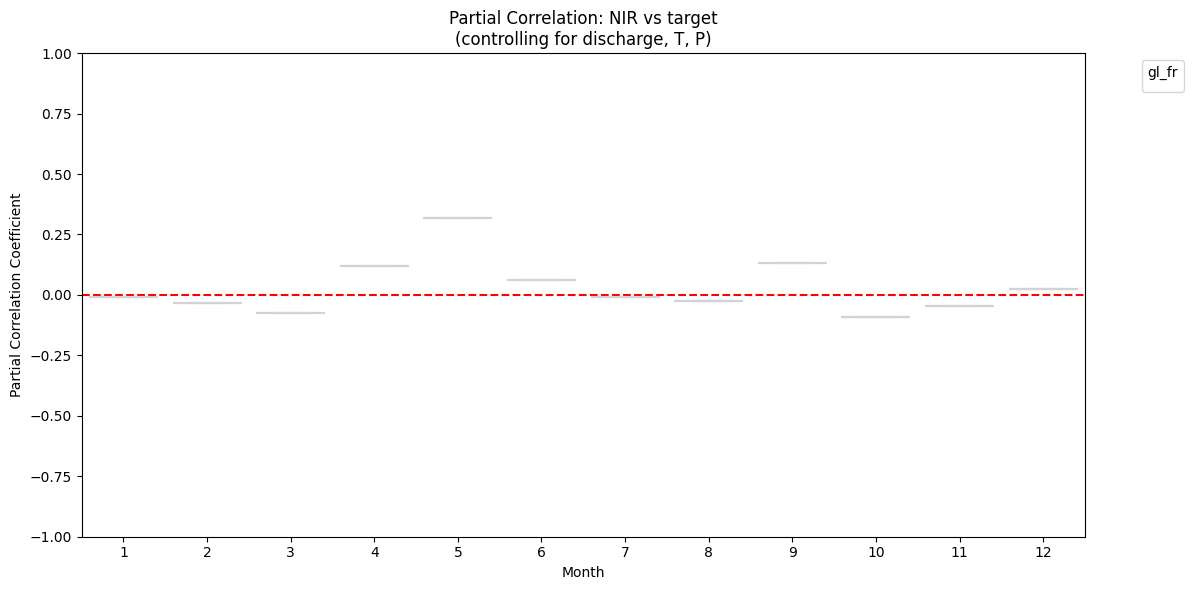

Calculating partial correlations for SLA_South vs target...
Controlling for: discharge_roll_mean_30, T_roll_mean_30, P_roll_sum_30


ValueError: DataFrame is missing required columns: SLA_South_roll_last_value_30

In [ ]:
# Load the data from the earlier section for partial correlation analysis
# We'll use the data from cell b36366a2 which has the month-end filtered data

# Get glacier fractions for plotting
gl_fractions = data[["code", "gl_fr"]].drop_duplicates().set_index("code")

print("Calculating partial correlations for NIR vs target...")
print("Controlling for: discharge_roll_mean_30, T_roll_mean_30, P_roll_sum_30")

# Calculate partial correlations
partial_corr_results = calculate_partial_correlations(
    data=data,
    x_col="NIR_roll_last_value_30",
    y_col="target",
    covar_cols=["discharge_roll_mean_15", "T_roll_mean_15", "P_roll_sum_30"],
)

print(f"\nCalculated {len(partial_corr_results)} partial correlations")
print(
    f"across {partial_corr_results['code'].nunique()} codes and "
    f"{partial_corr_results['month'].nunique()} months"
)
print("\nSummary statistics:")
print(partial_corr_results["partial_correlation"].describe())

# Plot the results
plot_monthly_partial_correlation(
    partial_corr_df=partial_corr_results,
    gl_fractions=gl_fractions,
    x_col="NIR",
    y_col="target",
    covar_names=["discharge", "T", "P"],
)

# partial correlation of SLA vs target
print("Calculating partial correlations for SLA_South vs target...")
print("Controlling for: discharge_roll_mean_30, T_roll_mean_30, P_roll_sum_30")
partial_corr_results = calculate_partial_correlations(
    data=data,
    x_col="SLA_South_roll_last_value_30",
    y_col="target",
    covar_cols=["discharge_roll_mean_15", "T_roll_mean_15", "P_roll_sum_30"],
)


# Plot the results
plot_monthly_partial_correlation(
    partial_corr_df=partial_corr_results,
    gl_fractions=gl_fractions,
    x_col="SLA_South",
    y_col="target",
    covar_names=["discharge", "T", "P"],
)

partial_corr_results = calculate_partial_correlations(
    data=data,
    x_col="SLA_North_roll_last_value_30",
    y_col="target",
    covar_cols=["discharge_roll_mean_15", "T_roll_mean_15", "P_roll_sum_30"],
)


# Plot the results
plot_monthly_partial_correlation(
    partial_corr_df=partial_corr_results,
    gl_fractions=gl_fractions,
    x_col="SLA_North",
    y_col="target",
    covar_names=["discharge", "T", "P"],
)

partial_corr_results = calculate_partial_correlations(
    data=data,
    x_col="fsc_basin_roll_last_value_30",
    y_col="target",
    covar_cols=["discharge_roll_mean_15", "T_roll_mean_15", "P_roll_sum_30"],
)

# Plot the results
plot_monthly_partial_correlation(
    partial_corr_df=partial_corr_results,
    gl_fractions=gl_fractions,
    x_col="fsc_basin",
    y_col="target",
    covar_names=["discharge", "T", "P"],
)

# partial correlation of discharge vs target
partial_corr_results = calculate_partial_correlations(
    data=data,
    x_col="discharge_roll_mean_30",
    y_col="target",
    covar_cols=["T_roll_mean_15", "P_roll_sum_30"],
)

# Plot the results
plot_monthly_partial_correlation(
    partial_corr_df=partial_corr_results,
    gl_fractions=gl_fractions,
    x_col="discharge",
    y_col="target",
    covar_names=["T", "P"],
)

## VIF (Variance Inflation Factor) Analysis

Analyze multicollinearity by calculating VIF for NIR alongside other predictors.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def calculate_vif(
    data: pd.DataFrame,
    feature_cols: list[str],
    *,
    month_col: str = "month",
) -> pd.DataFrame:
    """
    Calculate VIF (Variance Inflation Factor) for given features.

    Args:
        data: DataFrame containing the data
        feature_cols: List of feature column names to calculate VIF for
        month_col: Name of the month column

    Returns:
        DataFrame with VIF values for each feature, code, and month
    """
    required = set(feature_cols).union({month_col, "code"})
    missing = required.difference(data.columns)
    if missing:
        missing_str = ", ".join(sorted(missing))
        raise ValueError(f"DataFrame is missing required columns: {missing_str}")

    results = []

    for month in sorted(data[month_col].unique()):
        for code in sorted(data["code"].unique()):
            # Filter data for this month and code
            mask = (data[month_col] == month) & (data["code"] == code)
            subset = data.loc[mask, feature_cols].dropna()

            # Need sufficient observations for VIF calculation
            if len(subset) < len(feature_cols) + 2:
                continue
            # Check for zero variance columns
            if (subset.std() == 0).any():
                print(
                    f"Skipping month={month}, code={code} due to zero variance in features"
                )
                continue

            try:
                # Calculate VIF for each feature
                for i, feature in enumerate(feature_cols):
                    vif_value = variance_inflation_factor(subset.values, i)

                    results.append(
                        {
                            "month": month,
                            "code": code,
                            "feature": feature,
                            "vif": vif_value,
                        }
                    )
            except Exception as e:
                # Skip if calculation fails
                logger.debug(f"Failed for month={month}, code={code}: {e}")
                continue

    return pd.DataFrame(results)


def plot_monthly_vif(
    vif_df: pd.DataFrame,
    gl_fractions: pd.DataFrame,
    feature_name: str,
    *,
    jitter: float = 0.2,
    point_alpha: float = 0.8,
    figsize: tuple[int, int] = (12, 6),
) -> None:
    """
    Plot boxplots of VIF values by month for a specific feature.

    Args:
        vif_df: DataFrame with columns ['month', 'code', 'feature', 'vif']
        gl_fractions: DataFrame with glacier fractions indexed by code
        feature_name: Name of the feature to plot
        jitter: Amount of jitter for strip plot
        point_alpha: Transparency of points
        figsize: Figure size tuple
    """
    # Filter for the specific feature
    feature_data = vif_df[vif_df["feature"] == feature_name].copy()

    # Merge glacier fractions
    plot_data = feature_data.merge(gl_fractions.reset_index(), on="code", how="left")

    plt.figure(figsize=figsize)
    sns.boxplot(
        data=plot_data,
        x="month",
        y="vif",
        fill=False,
        color="lightgray",
    )
    sns.stripplot(
        data=plot_data,
        x="month",
        y="vif",
        hue="gl_fr",
        alpha=point_alpha,
        palette="magma",
        jitter=jitter,
    )

    # make y log scale
    plt.yscale("log")

    plt.title(f"VIF Analysis: {feature_name}")
    plt.xlabel("Month")
    plt.ylabel("VIF Value")
    plt.axhline(5, color="orange", linestyle="--", label="VIF=5 (moderate)")
    plt.axhline(10, color="red", linestyle="--", label="VIF=10 (high)")
    plt.legend(title="gl_fr", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

Calculating VIF for features...
Features: discharge_roll_mean_15, T_roll_mean_15, P_roll_sum_30, fsc_basin_roll_last_value_30
Skipping month=5, code=16143 due to zero variance in features
Skipping month=6, code=16135 due to zero variance in features
Skipping month=6, code=16143 due to zero variance in features
Skipping month=7, code=15013 due to zero variance in features
Skipping month=7, code=16134 due to zero variance in features
Skipping month=7, code=16135 due to zero variance in features
Skipping month=7, code=16139 due to zero variance in features
Skipping month=7, code=16143 due to zero variance in features
Skipping month=7, code=16146 due to zero variance in features
Skipping month=7, code=16151 due to zero variance in features
Skipping month=7, code=16176 due to zero variance in features
Skipping month=8, code=15013 due to zero variance in features
Skipping month=8, code=15090 due to zero variance in features
Skipping month=8, code=16105 due to zero variance in features
Skippi

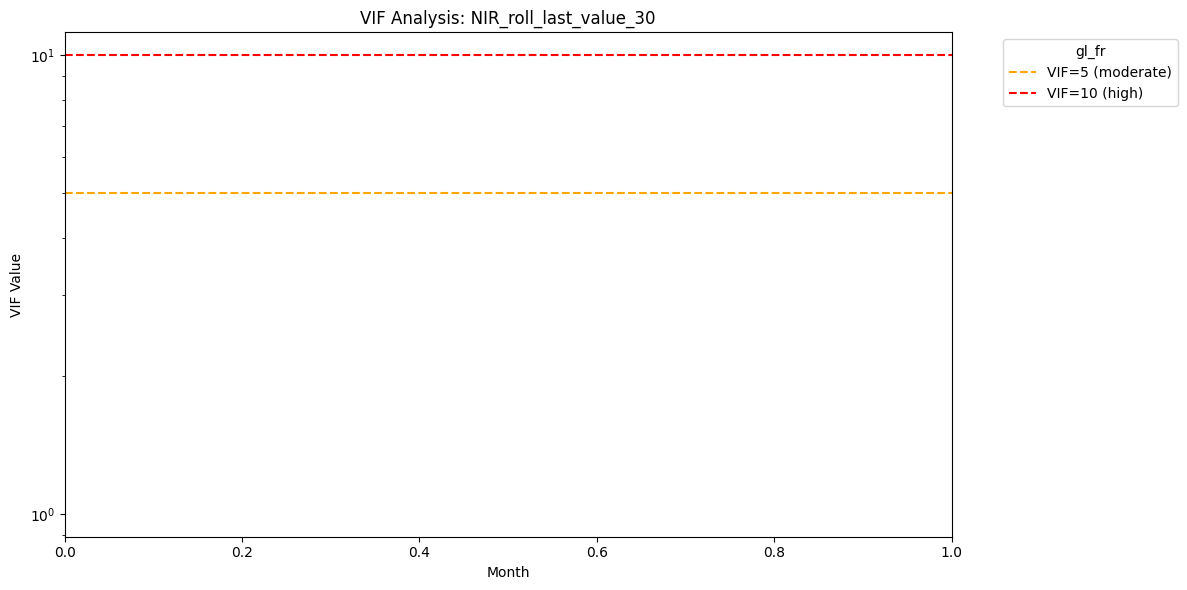


Plotting VIF for fsc_basin...


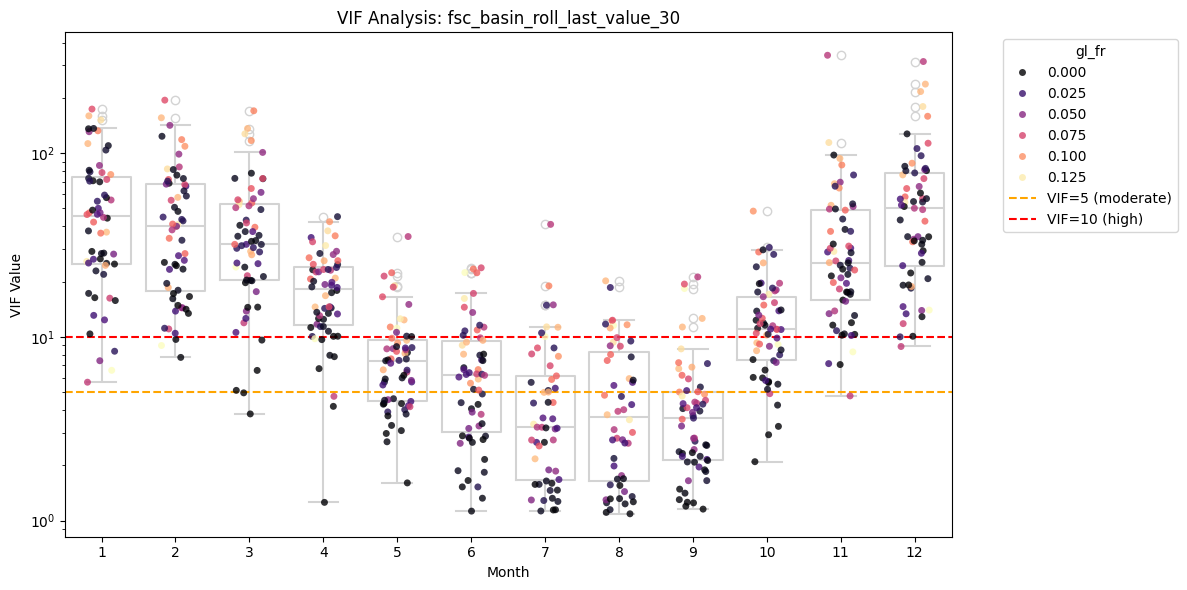

In [ ]:
# Calculate VIF for NIR and other key predictors
feature_cols_for_vif = [
    "NIR_roll_last_value_30",
    "discharge_roll_mean_15",
    "T_roll_mean_15",
    "P_roll_sum_30",
    # "fsc_basin_roll_last_value_30",
]

print("Calculating VIF for features...")
print(f"Features: {', '.join(feature_cols_for_vif)}")

# Calculate VIF
vif_results = calculate_vif(
    data=data,
    feature_cols=feature_cols_for_vif,
)

print(f"\nCalculated {len(vif_results)} VIF values")
print(
    f"across {vif_results['code'].nunique()} codes and "
    f"{vif_results['month'].nunique()} months"
)

# Summary statistics for each feature
print("\nVIF Summary by Feature:")
for feature in feature_cols_for_vif:
    feature_vif = vif_results[vif_results["feature"] == feature]["vif"]
    print(f"\n{feature}:")
    print(feature_vif.describe())

# Plot VIF for NIR
print("\nPlotting VIF for NIR...")
plot_monthly_vif(
    vif_df=vif_results,
    gl_fractions=gl_fractions,
    feature_name="NIR_roll_last_value_30",
)

# Plot VIF for other features for comparison
print("\nPlotting VIF for fsc_basin...")
plot_monthly_vif(
    vif_df=vif_results,
    gl_fractions=gl_fractions,
    feature_name="fsc_basin_roll_last_value_30",
)

## Predictability Analysis

Predict NIR and fsc_basin using discharge, P, and T to assess how much these variables explain each feature.

In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


def calculate_predictability_r2(
    data: pd.DataFrame,
    target_col: str,
    predictor_cols: list[str],
    *,
    month_col: str = "month",
) -> pd.DataFrame:
    """
    Predict target using predictors and calculate R² for each code and month.

    Args:
        data: DataFrame containing the data
        target_col: Name of the target variable column (e.g., 'NIR_roll_last_value_30')
        predictor_cols: List of predictor column names
        month_col: Name of the month column

    Returns:
        DataFrame with R² values for each code and month
    """
    required = {target_col, month_col, "code"}.union(set(predictor_cols))
    missing = required.difference(data.columns)
    if missing:
        missing_str = ", ".join(sorted(missing))
        raise ValueError(f"DataFrame is missing required columns: {missing_str}")

    results = []

    for month in sorted(data[month_col].unique()):
        for code in sorted(data["code"].unique()):
            # Filter data for this month and code
            mask = (data[month_col] == month) & (data["code"] == code)
            subset = data.loc[mask, [target_col] + predictor_cols].dropna()

            # Need sufficient observations for regression
            if len(subset) < len(predictor_cols) + 2:
                continue

            try:
                # Prepare data
                X = subset[predictor_cols].values
                y = subset[target_col].values

                # Fit linear regression
                model = LinearRegression()
                model.fit(X, y)

                # Calculate R²
                y_pred = model.predict(X)
                r2 = r2_score(y, y_pred)

                results.append(
                    {
                        "month": month,
                        "code": code,
                        "r2": r2,
                    }
                )
            except Exception as e:
                # Skip if calculation fails
                logger.debug(f"Failed for month={month}, code={code}: {e}")
                continue

    return pd.DataFrame(results)


def plot_monthly_r2(
    r2_df: pd.DataFrame,
    gl_fractions: pd.DataFrame,
    target_name: str,
    predictor_names: list[str],
    *,
    jitter: float = 0.2,
    point_alpha: float = 0.8,
    figsize: tuple[int, int] = (12, 6),
) -> None:
    """
    Plot boxplots of R² values by month.

    Args:
        r2_df: DataFrame with columns ['month', 'code', 'r2']
        gl_fractions: DataFrame with glacier fractions indexed by code
        target_name: Name of target variable (for title)
        predictor_names: List of predictor names (for title)
        jitter: Amount of jitter for strip plot
        point_alpha: Transparency of points
        figsize: Figure size tuple
    """
    # Merge glacier fractions
    plot_data = r2_df.merge(gl_fractions.reset_index(), on="code", how="left")

    plt.figure(figsize=figsize)
    sns.boxplot(
        data=plot_data,
        x="month",
        y="r2",
        fill=False,
        color="lightgray",
    )
    sns.stripplot(
        data=plot_data,
        x="month",
        y="r2",
        hue="gl_fr",
        alpha=point_alpha,
        palette="magma",
        jitter=jitter,
    )
    plt.legend(title="gl_fr", bbox_to_anchor=(1.05, 1), loc="upper left")

    predictor_str = ", ".join(predictor_names)
    plt.title(f"R² for predicting {target_name}\nusing {predictor_str}")
    plt.xlabel("Month")
    plt.ylabel("R² Score")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

Calculating R² for predicting NIR using discharge, T, and P...

Calculated 732 R² values for NIR
across 61 codes and 12 months

NIR R² Summary:
count    732.000000
mean       0.433936
std        0.252192
min        0.007436
25%        0.241459
50%        0.402808
75%        0.597170
max        1.000000
Name: r2, dtype: float64


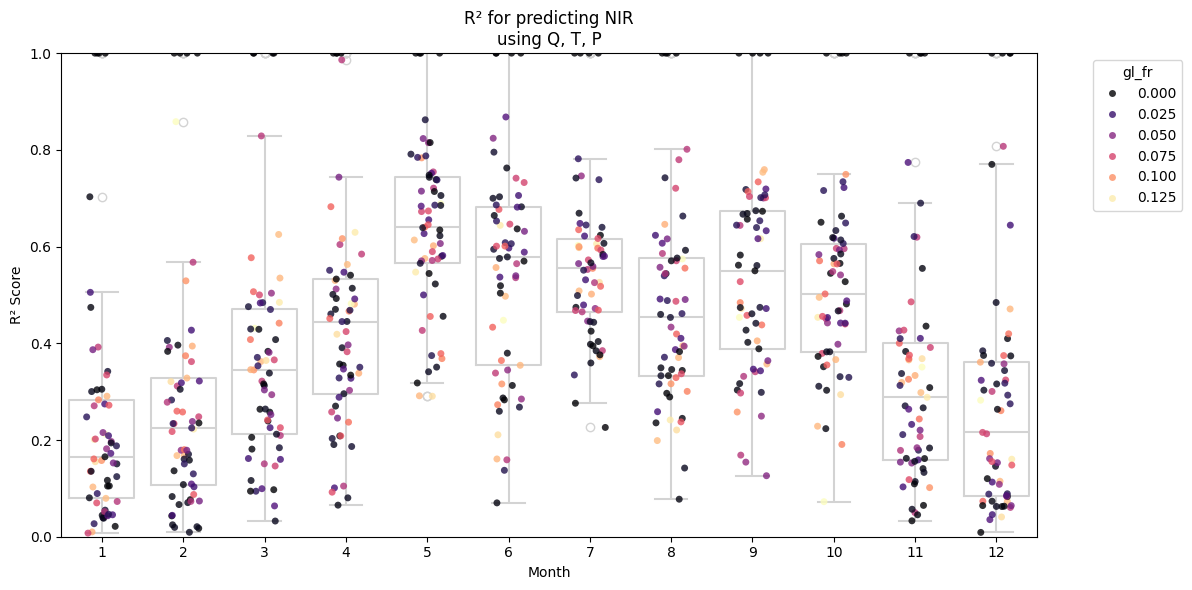


Calculating R² for predicting fsc_basin using T and P...

Calculated 732 R² values for fsc_basin
across 61 codes and 12 months

fsc_basin R² Summary:
count    732.000000
mean       0.490453
std        0.223978
min        0.004984
25%        0.320863
50%        0.496105
75%        0.652787
max        1.000000
Name: r2, dtype: float64


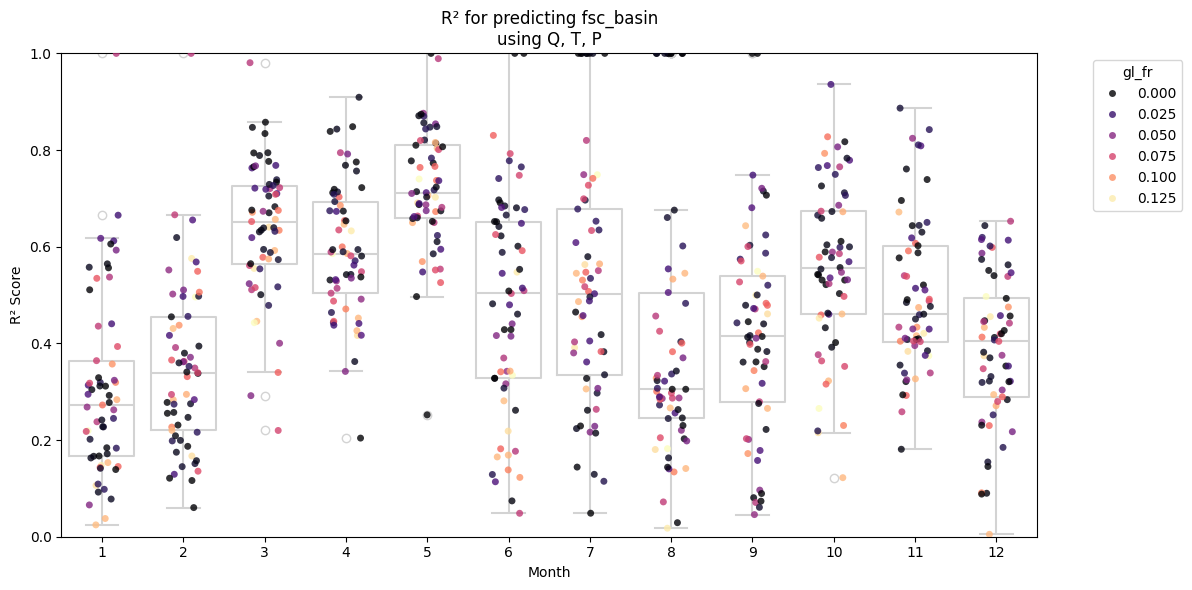


Comparison of R² values:
Mean R² for NIR: 0.434
Mean R² for fsc_basin: 0.490

Median R² for NIR: 0.403
Median R² for fsc_basin: 0.496


In [98]:
# Define predictors
predictor_cols = ["discharge_roll_mean_30", "T_roll_mean_30", "P_roll_sum_30"]
data["month"] = data["date"].dt.month
# Calculate R² for predicting NIR
print("Calculating R² for predicting NIR using discharge, T, and P...")
r2_nir = calculate_predictability_r2(
    data=data,
    target_col="NIR_roll_last_value_30",
    predictor_cols=predictor_cols,
)

print(f"\nCalculated {len(r2_nir)} R² values for NIR")
print(f"across {r2_nir['code'].nunique()} codes and {r2_nir['month'].nunique()} months")
print("\nNIR R² Summary:")
print(r2_nir["r2"].describe())

gl_fractions = data[["code", "gl_fr"]].drop_duplicates().set_index("code")

# Plot R² for NIR
plot_monthly_r2(
    r2_df=r2_nir,
    gl_fractions=gl_fractions,
    target_name="NIR",
    predictor_names=["Q", "T", "P"],
)

# Calculate R² for predicting fsc_basin
print("\n" + "=" * 60)
print("Calculating R² for predicting fsc_basin using T and P...")
r2_fsc = calculate_predictability_r2(
    data=data,
    target_col="fsc_basin_roll_last_value_30",
    predictor_cols=predictor_cols,
)

print(f"\nCalculated {len(r2_fsc)} R² values for fsc_basin")
print(f"across {r2_fsc['code'].nunique()} codes and {r2_fsc['month'].nunique()} months")
print("\nfsc_basin R² Summary:")
print(r2_fsc["r2"].describe())

# Plot R² for fsc_basin
plot_monthly_r2(
    r2_df=r2_fsc,
    gl_fractions=gl_fractions,
    target_name="fsc_basin",
    predictor_names=["Q", "T", "P"],
)

# Compare the two
print("\n" + "=" * 60)
print("Comparison of R² values:")
print(f"Mean R² for NIR: {r2_nir['r2'].mean():.3f}")
print(f"Mean R² for fsc_basin: {r2_fsc['r2'].mean():.3f}")
print(f"\nMedian R² for NIR: {r2_nir['r2'].median():.3f}")
print(f"Median R² for fsc_basin: {r2_fsc['r2'].median():.3f}")

Calculating R² for predicting NIR using discharge, T, and P...

Calculated 732 R² values for NIR
across 61 codes and 12 months

NIR R² Summary:
count    732.000000
mean       0.355201
std        0.221639
min        0.009280
25%        0.164606
50%        0.320351
75%        0.531250
max        1.000000
Name: r2, dtype: float64


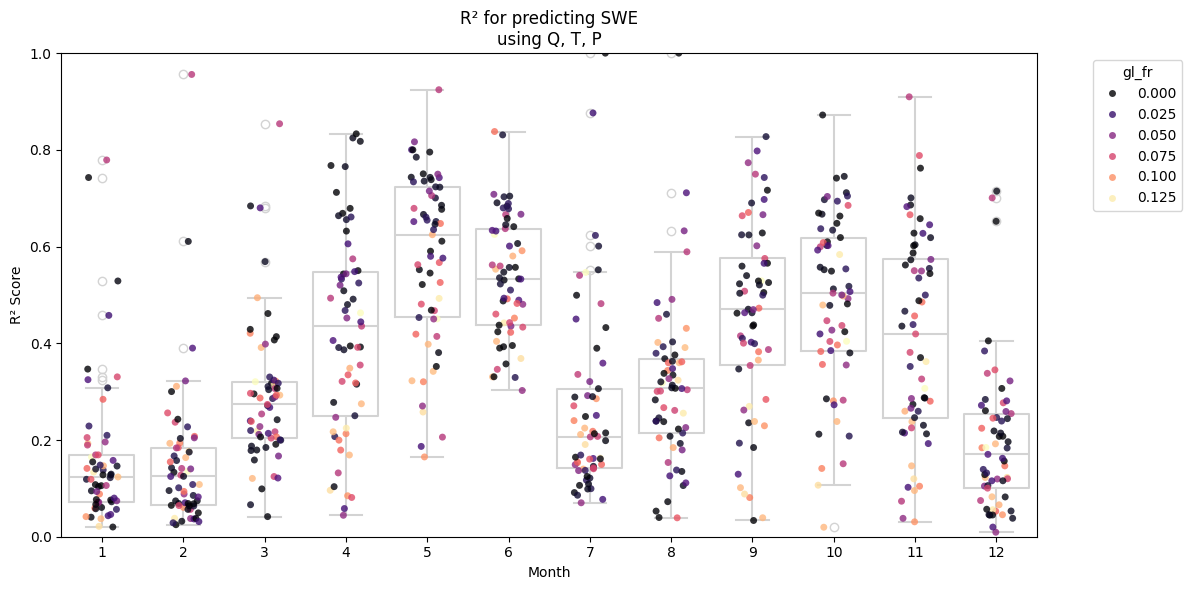

In [100]:
# Define predictors
predictor_cols = ["discharge_roll_mean_30", "T_roll_mean_30", "P_roll_sum_30"]
data["month"] = data["date"].dt.month
# Calculate R² for predicting NIR
print("Calculating R² for predicting NIR using discharge, T, and P...")
r2_nir = calculate_predictability_r2(
    data=data,
    target_col="SWE_roll_mean_30",
    predictor_cols=predictor_cols,
)

print(f"\nCalculated {len(r2_nir)} R² values for NIR")
print(f"across {r2_nir['code'].nunique()} codes and {r2_nir['month'].nunique()} months")
print("\nNIR R² Summary:")
print(r2_nir["r2"].describe())

gl_fractions = data[["code", "gl_fr"]].drop_duplicates().set_index("code")

# Plot R² for NIR
plot_monthly_r2(
    r2_df=r2_nir,
    gl_fractions=gl_fractions,
    target_name="SWE",
    predictor_names=["Q", "T", "P"],
)